In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, uniform
from smoother import MaxEntropy

import math

c:\users\dbspe\smoother\smoother\max_entropy.py:70: RuntimeWarning: overflow encountered in exp
  sum([param*f(x) for param, f in zip(params, self._moment_funcs)])
C:\Users\DBSpe\studies\fcast-demo\hemlock-venv\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\users\dbspe\smoother\smoother\max_entropy.py:70: RuntimeWarning: overflow encountered in exp
  sum([param*f(x) for param, f in zip(params, self._moment_funcs)])
c:\users\dbspe\smoother\smoother\max_entropy.py:70: RuntimeWarning: overflow encountered in exp
  sum([param*f(x) for param, f in zip(params, self._moment_funcs)])
C:\Users\DBSpe\studies\fcast-demo\hemlock-venv\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\users\dbspe\smoother\smoother\max_entropy.py:70: RuntimeWarning: overflow encountered in exp
  sum([param*f(x) for param, f in zip(params, self._moment_funcs)])


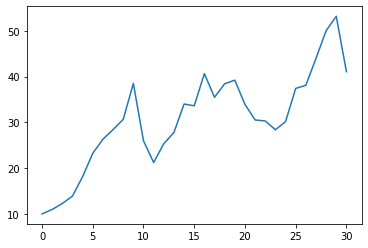

In [19]:
class Demand(MaxEntropy):
    def __init__(self, const=0, a=0, b=0, p=0, sigma=1, season=[]):
        self.const = const
        self.a = a
        self.b = b
        self.p = p
        self.sigma = sigma
        self.season = season
        
    def fit(self, x_t, t):
        mu = (
            self.const
            + self.b*(t+1) # time trend
            + self.p*(x_t-self.const) # serial correlation
            + (0 if not self.season else self.season[(t+1)%len(self.season)]) # seasonality
        )
        sigma = self.sigma + self.a*x_t # heteroskedastic error
        moment_funcs = [lambda x: x, lambda x: (x-mu)**2]
        values = [mu, sigma**2]
        return super().fit(0, mu+2.58*sigma, moment_funcs, values)
        
    
demand = Demand(10, p=.7, a=.1, b=.2, sigma=0, season=2*list(range(10)))
x_t = 10
x = [x_t]
for t in range(30):
    x_t = demand.fit(x_t, t).rvs()
    x.append(x_t)
plt.plot(x)

mean 39.43489206143039


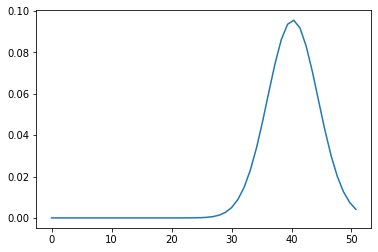

In [20]:
demand.fit(x[-1], len(x))
print('mean', demand.mean())
plt.plot(demand.x, demand.f_x)

In [21]:
def compute_exp_profit(demand, supply, price, cost, size=1000):
    x = demand.rvs(size=size)
    purchased = np.clip(x, 0, supply)
    return price*purchased.mean() - cost*supply    

def maximize(demand, price, cost, tol=.01, maxiter=100, size=1000):
    def compute_exp_profit(q):
        supply = demand.ppf(q)
        purchased = np.clip(x, 0, supply)
        return supply, price*purchased.mean() - cost*supply
        
    x = demand.rvs(size=size)
    opt_supply, max_exp_profit = 0, 0
    q, step = 0, 1
    for i in range(maxiter):
        supply, exp_profit = compute_exp_profit(q)
        delta = exp_profit - max_exp_profit
        if delta >= 0:
            opt_supply = supply
            max_exp_profit = exp_profit
        step /= 2
        q += step if delta>=0 else -step
        if i>0 and abs(delta) < tol:
            break
    return opt_supply, max_exp_profit

In [23]:
maximize(demand, 100, 30)

(43.01822815734764, 2650.792849540181)

In [17]:
def compute_profit_index(demand, forecast, target, baseline, price, cost, size=1000):
    def compute_exp_profit(dist):
        supply, _ = maximize(dist, price, cost)
        purchased = np.clip(x, 0, supply)
        return price*purchased.mean() - cost*supply
    
    x = demand.rvs(size=size)
    fcast_profit = compute_exp_profit(forecast)
    target_profit = compute_exp_profit(target)
    base_profit = compute_exp_profit(baseline)
    return (fcast_profit - base_profit) / (target_profit - base_profit)    

price, cost = 5, 1
demand.fit(25, 10)
baseline = uniform(demand.ppf(.01), demand.ppf(.99))
compute_profit_index(demand, demand, demand, baseline, price, cost)

1.0087609940066418